# Computational Mathematics 1: Exercise Sheet 1

## Example 1.2: Polynomial Evaluation using Horner's Method

Write a python-script containing the function `horner(a, x)` implementing the algorithm for evaluating a polynomial $p\in\mathbb{R}_n[x]$ for a certain value of $x$, where 
$\bm{a}\in\R^{n+1}$ contains the coefficients of $p(x)$:

$$
    p(x) = \sum_{k=0}^{n+1}\langle\bm{a},\bm{e}_k\rangle x^k
$$

Write another function `plot_poly(a, x1, x2)` wich returns a visualization of the polynomial
defined by $\bm{a}$ over the interval $[x_1,x_2]$. Test the program for the following 
settings:

1. $\bm{a} = \begin{bmatrix}1 & -8 & 4\end{bmatrix}$, $x_1=0$ and $x_2=4$
2. $\bm{a} = \begin{bmatrix}2 & 0 & -1 & 0\end{bmatrix}$, $x_1=-2$ and $x_2=2$
3. $\bm{a} = \begin{bmatrix}4 & 2 & -3 & -4 & 8\end{bmatrix}$, $x_1=-4$ and $x_2=3$

The code cell below organizes imports and any global variables used, as well as any global setup for `matplotlib`.

In [17]:
from numpy import ndarray, pad, linspace, array, flip, trim_zeros
from typing import Callable, Iterator
from scipy.special import factorial
from matplotlib.pyplot import Axes
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

text_colors = {
    'jupyter': 'white',
    'regular': 'black'
}

mode = 'regular'
plot_params = {
    'axes.labelcolor': text_colors[mode],
    'xtick.color': text_colors[mode],
    'ytick.color': text_colors[mode],
    'text.usetex': True,
    'font.size': 18,
    'grid.linestyle': '--'
}

plt.rcParams.update(plot_params)

# constants
    
axis_resolution = 400
fig_height_in = 12
fig_width_in  = 12

def get_sign_string(a : float) -> str:
    if a > 0:
        return '+'
    else:
        return '-'

We begin by writing a generic polynomial class, which only takes an array of coefficients
as a parameter for the constructor. Any trailing zeros from the passed array are removed, then
the coefficients are stored as a member. The advantage of using classes lies in the fact that
we can easily overwrite special methods, like `__call__` or `__iter__` for calling/iterating 
the instance. Additionally, as polynomials lend themselves very well as vectors, we want to
implement common operations, such as addition and subtraction. Note that multiplication 
defined by `__mul__` only returns a callable function, to avoid computing the 
coefficients of the product. This is not a problem, as long as the used polynomials remain in
the given scope. In that sense the implementation below is problematic. Similarly, division 
achieved by `__truediv__` only returns a callable object.

In [18]:
from __future__ import annotations
class Polynomial:
    
    def __init__(self, coefficients : ndarray) -> None:
        self._coeffs = trim_zeros(coefficients, 'b')
        
    def __call__(self, x : float) -> float:
        return list(self.get_evals(x))[-1]    
    
    def __iter__(self) -> Iterator[float]:
        for a in self._coeffs:
            yield a
            
    @property
    def deg(self) -> int:
        return len(self._coeffs)            

    def __add__(self, other : Polynomial) -> Polynomial:
        slen = len(self._coeffs)
        olen = len(other._coeffs)
        coeffs_1 = pad(self._coeffs,  (0, abs(slen - max(slen,olen))), 'constant')
        coeffs_2 = pad(other._coeffs, (0, abs(olen - max(slen,olen))), 'constant')
        return Polynomial(coeffs_1 + coeffs_2)
    
    def get_evals(self, x : float) -> Iterator[float]:
        xi_prev = self._coeffs[-1]
        for a in flip(self._coeffs[:-1]):
            yield xi_prev
            xi_prev = x * xi_prev + a
        yield xi_prev
        
    def arrval(self, x : ndarray) -> ndarray:
        return array([self(xv) for xv in x])

    def __sub__(self, other : Polynomial) -> Polynomial:
        slen = len(self._coeffs)
        olen = len(other._coeffs)
        coeffs_1 = pad(self._coeffs,  (0, abs(slen - max(slen,olen))), 'constant')
        coeffs_2 = pad(other._coeffs, (0, abs(olen - max(slen,olen))), 'constant')
        return Polynomial(coeffs_1 - coeffs_2)        
    
    def __mul__(self, other : Polynomial) -> Callable[[float],float]:
        def product(x : float) -> float:
            return self(x) * other(x)
        return product
    
    def __truediv__(self, other : Polynomial) -> Callable[[float], float]:
        def division(x : float) -> float:
            return self(x) / other(x)
        return division
    
    def __getitem__(self, k : int) -> float:
        if k < 0 or k >= len(self._coeffs):
            raise ValueError(f'index {k} out of range')
        return self._coeffs[k]
    
    def __str__(self) -> str:
        rval = ''
        sign = ''
        for k,a in enumerate(self._coeffs):
            if a != 0.0:
                if k == 0:
                    rval += f'{a}'
                else:
                    sign = get_sign_string(a)
                    rval += f'  {sign}  {abs(a)} * x^{k}'
        rval = rval.replace('x^1', 'x').replace('1 * x', 'x')
        
        return rval
    
    def get_latex_string(self) -> str:
        r_string = str(self).replace('*', '').replace('  +   ', '+').replace('  -  ', '-')
        return rf'${r_string}$'
    
    def plot(self, x1 : float, x2 : float, ax : Axes) -> Line2D:
        if x1 >= x2:
            raise ValueError(f'invalid plotting inverval [{x1},{x2}]')
        x = linspace(x1, x2, 300)
        ax.set_title(self.get_latex_string() + ' for ' + rf'$x\in[{x1},{x2}]$',color=text_colors[mode])
        ax.grid()
        ax.set_xlabel(r'$x$')
        return ax.plot(x, self(x))

The `plot()` methods takes the given x-range, verifies it and plots the calling polynomial on the passed 
`Axes` object. If `x1 > x2`, then the method raises a `ValueError`.

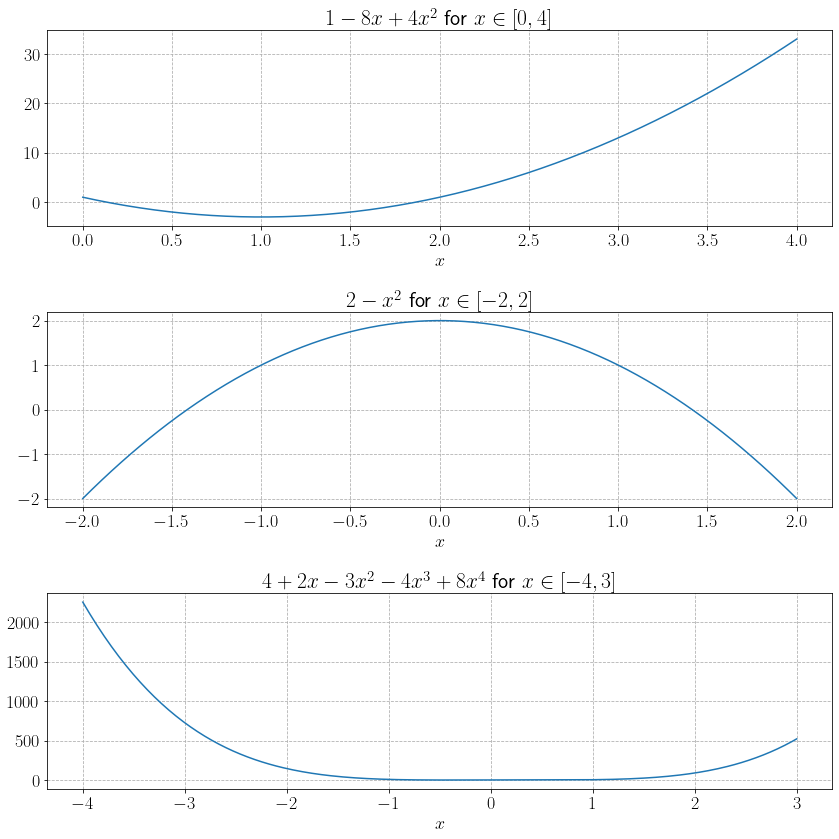

In [19]:
p1 = Polynomial([1,-8,4])
p2 = Polynomial([2,0,-1,0])
p3 = Polynomial([4,2,-3,-4,8])

fig, ax = plt.subplots(3)

p1.plot(0 , 4, ax[0])
p2.plot(-2, 2, ax[1])
p3.plot(-4,3, ax[2])    

fig.set_size_inches(fig_width_in, fig_height_in)
fig.tight_layout()

plt.show()
fig.savefig('ex_2.png', dpi=300)